In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
import warnings
warnings.filterwarnings('ignore')


In [10]:
# Load the dataset
file_path = '../data/ckd-dataset-v2.csv'  # Go up one directory, then into data
data = pd.read_csv(file_path)

# Display basic information about the dataset
print("Dataset shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

# Check data types and missing values
print("\nData types:")
print(data.dtypes)
print("\nMissing values per column:")
print(data.isnull().sum())

# Summary statistics for numerical columns
print("\nSummary statistics:")
print(data.describe())

# Check class distribution (imbalance)
print("\nClass distribution:")
print(data['class'].value_counts())
print(data['class'].value_counts(normalize=True).round(3) * 100, "%")

Dataset shape: (202, 29)

First 5 rows:
  bp (Diastolic)  bp limit             sg        al     class       rbc  \
0       discrete  discrete       discrete  discrete  discrete  discrete   
1            NaN       NaN            NaN       NaN       NaN       NaN   
2              0         0  1.019 - 1.021     1 - 1       ckd         0   
3              0         0  1.009 - 1.011       < 0       ckd         0   
4              0         0  1.009 - 1.011       ≥ 4       ckd         1   

         su        pc       pcc        ba  ...       htn        dm       cad  \
0  discrete  discrete  discrete  discrete  ...  discrete  discrete  discrete   
1       NaN       NaN       NaN       NaN  ...       NaN       NaN       NaN   
2       < 0         0         0         0  ...         0         0         0   
3       < 0         0         0         0  ...         0         0         0   
4       < 0         1         0         1  ...         0         0         0   

      appet        pe       

Data types before conversion:
- sg: object
- al: object
- su: object
- bgr: float64
- bu: float64
- sc: object
- sod: float64
- pot: float64
- hemo: float64
- pcv: float64
- wbcc: float64
- rbcc: float64
- grf: float64
- age: float64

Numeric conversion successful

Columns after conversion:
- sg: object
- al: object
- su: object
- bgr: float64
- bu: float64
- sc: object
- sod: float64
- pot: float64
- hemo: float64
- pcv: float64
- wbcc: float64
- rbcc: float64
- grf: float64
- age: float64
Converted htn to binary format
Converted dm to binary format
Converted cad to binary format
Converted appet to binary format
Converted pe to binary format
Converted ane to binary format
Error converting class: 'in <string>' requires string as left operand, not int
Created missing values heatmap
Created correlation matrix


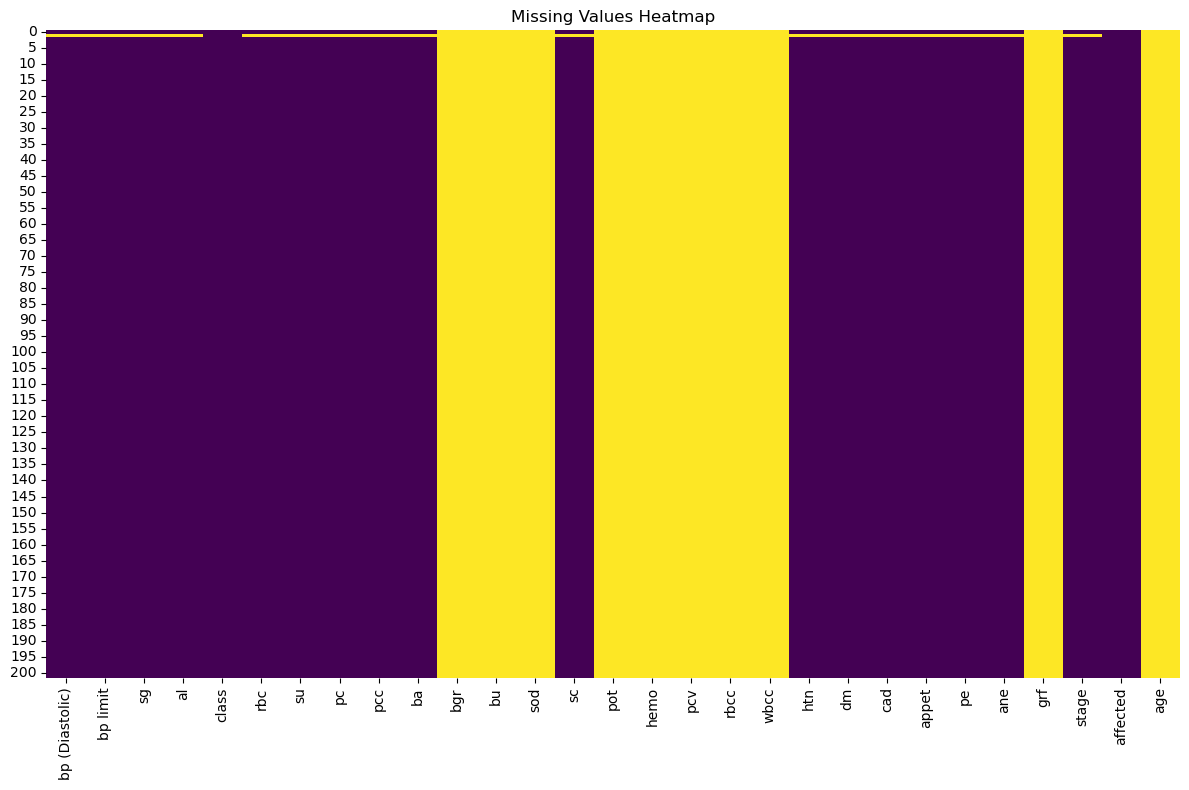

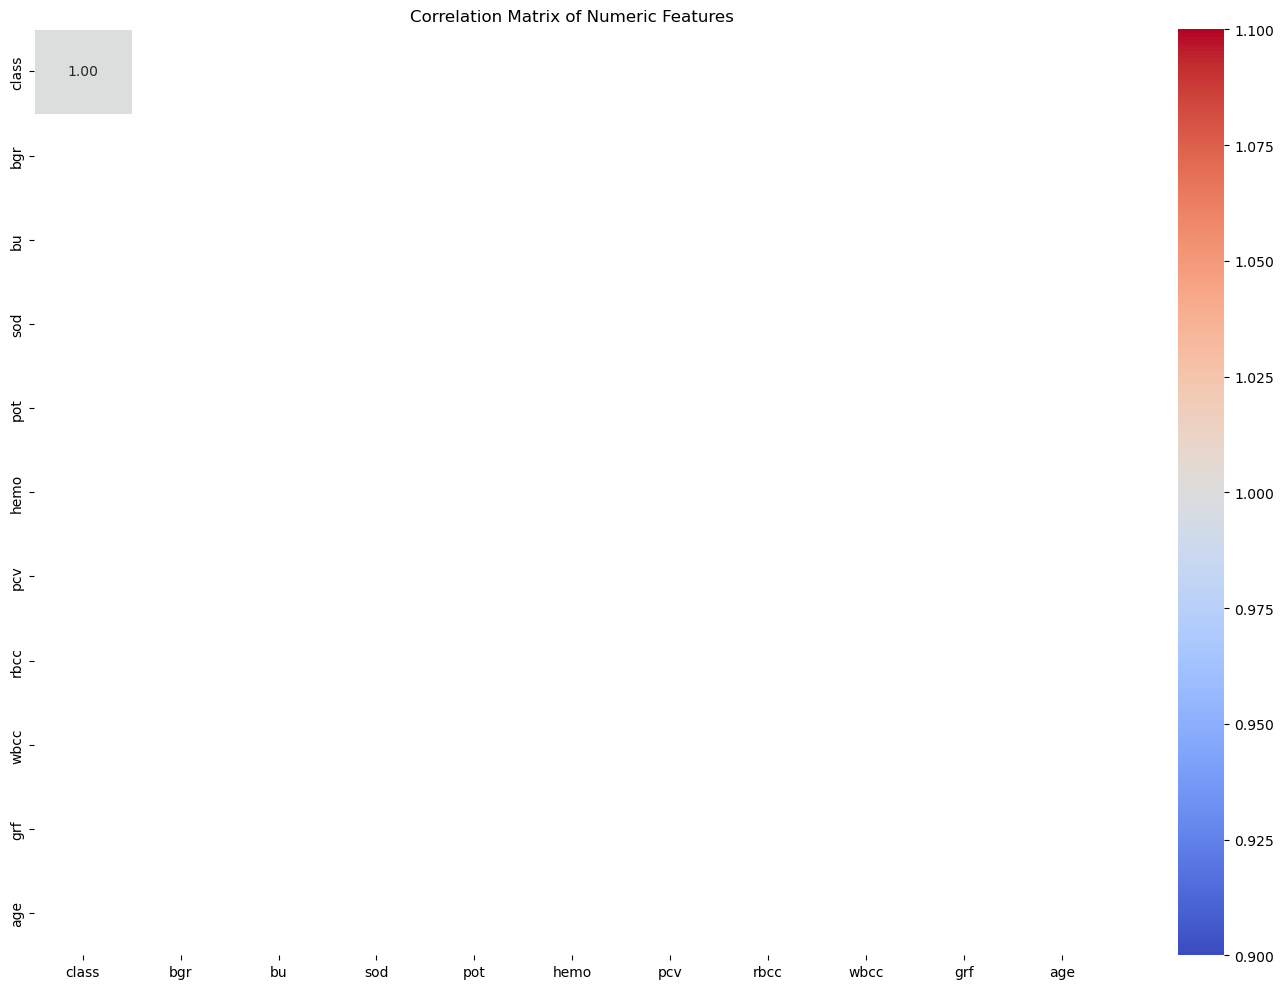

In [13]:
# Function to convert possible numeric columns to float - simplified version
def convert_to_numeric(df, columns_to_try):
    """
    Convert specified columns to numeric, handling special notations.
    """
    df_copy = df.copy()
    
    for col in columns_to_try:
        if col in df.columns:
            # For columns with special notations
            if df[col].dtype == 'object':  # Only process string columns
                # Replace special notations with numeric values
                # First save original to compare later
                original_series = df[col].copy()
                temp_series = df[col].copy()
                
                # Try simple replacements
                # Replace '< 0' with '-0.1'
                temp_series = temp_series.replace('< 0', '-0.1')
                # Replace other patterns as needed
                temp_series = temp_series.replace('≥ 4', '4.0')
                
                # Attempt numeric conversion
                df_copy[col] = pd.to_numeric(temp_series, errors='coerce')
                
                # Check if we made things worse
                if df_copy[col].isna().sum() > original_series.isna().sum():
                    # Revert to original if we introduced more NaNs
                    df_copy[col] = original_series
            else:
                # For already numeric columns, just ensure they're float
                try:
                    df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
                except:
                    pass  # Keep original if conversion fails
    
    return df_copy

# Identify potential numeric columns 
potential_numeric_cols = [
    'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 
    'hemo', 'pcv', 'wbcc', 'rbcc', 'grf', 'age'
]

# Print data types before conversion
print("Data types before conversion:")
for col in potential_numeric_cols:
    if col in data.columns:
        print(f"- {col}: {data[col].dtype}")

# Try to convert potential numeric columns with a safer approach
try:
    data_numeric = convert_to_numeric(data, potential_numeric_cols)
    print("\nNumeric conversion successful")
except Exception as e:
    print(f"\nError during conversion: {e}")
    # Fall back to original data
    data_numeric = data.copy()

# Check the result of conversions
print("\nColumns after conversion:")
for col in potential_numeric_cols:
    if col in data_numeric.columns:
        print(f"- {col}: {data_numeric[col].dtype}")

# Create a safer function for binary conversion
def convert_to_binary(df, column):
    """
    Safely convert a column to binary (0/1) format.
    Returns the converted series or the original if conversion isn't possible.
    """
    if column not in df.columns:
        return None
    
    # Get unique values, excluding NaN
    unique_vals = df[column].dropna().unique()
    
    # Skip if more than 2 unique values (not binary)
    if len(unique_vals) > 2:
        return df[column]
    
    # Try to identify yes/no patterns
    yes_values = ['yes', 'y', 'true', 't', '1', 1, 'ckd']
    no_values = ['no', 'n', 'false', 'f', '0', 0, 'notckd']
    
    # Create mapping dict based on actual values
    value_map = {}
    for val in unique_vals:
        str_val = str(val).lower()
        if any(yes in str_val for yes in yes_values):
            value_map[val] = 1
        elif any(no in str_val for no in no_values):
            value_map[val] = 0
    
    # Apply mapping if we have a valid mapping for all values
    if len(value_map) == len(unique_vals):
        return df[column].map(value_map)
    else:
        return df[column]  # Return original if mapping didn't work

# Identify and convert binary columns
binary_cols = ['htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']

for col in binary_cols:
    try:
        converted = convert_to_binary(data_numeric, col)
        if converted is not None:
            data_numeric[col] = converted
            print(f"Converted {col} to binary format")
    except Exception as e:
        print(f"Error converting {col}: {e}")

# Visualize missing values
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(data_numeric.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.tight_layout()
    plt.savefig('missing_values_heatmap.png')
    print("Created missing values heatmap")
except Exception as e:
    print(f"Error creating heatmap: {e}")

# Try to create a basic correlation matrix with only numeric columns
try:
    plt.figure(figsize=(14, 10))
    # Only include columns that are actually numeric
    numeric_cols = data_numeric.select_dtypes(include=['number']).columns
    if len(numeric_cols) >= 2:  # Need at least 2 columns for correlation
        correlation = data_numeric[numeric_cols].corr()
        sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
        plt.title('Correlation Matrix of Numeric Features')
        plt.tight_layout()
        plt.savefig('correlation_matrix.png')
        print("Created correlation matrix")
    else:
        print("Not enough numeric columns for correlation matrix")
except Exception as e:
    print(f"Error creating correlation matrix: {e}")